# Speed Calculation

This notebook looks at calculating and visualizing a riders speed - other analysis will follow.  Before this analysis the data had to be prepared and transformed - see time transformation workbook.

This notebook will refer frequently to "raw speed".  Raw speed refers to taking the data as is from the Garmin computer and dividing distance by time.  Due to anomolies in how the Garming computer records data this will give misleading results.  It is necessary to apply data science algotithms to provide accurate speed measures.

Key-words:  time instance,  point in time,  zoom in, Python

## Approach
The standard web-sites, such as Garmin and Strava, only provide summary aggregated information.  What is different about this notebook is the ability to give tailored, specific, event driven information with full access to the Python powered modern data science tool-kits:
- **point in time analysis** - user can zoom in to any point of time within the activity period.  They can zero in on events of interest to them based on time.  The examples in this notebook are events relating to highest and second highest raw speeds.  On maps we are used to zooming in on the space dimension - point in time analysis is zooming using the time dimension.  This allows the user to drill into their performance for detailed information at those instances that can provide them with an edge.
- **variable time window** - the user can choose the amount of contextual data they view either side of the event's point in time.  They can select start and end time of a variable time window.  In the examples in the workbook these are 60 second time windows - but the time window can easily be customized.  By specifying the time window the user can get exactly the right amount of context to understand an event of interest.
- **choice of time series algorithms** - this workbook shows the application of a mean weighted time series algorithm.  Again this algorithm can be customized - or other data science algorothms applied.  The choise of algorithm opens up the events to analysis by the full data science and predictive analytics toolbox.
- **build on Python** - Python is the world's leading open source platform for data science and analytics.  This analysis uses Python Pandas which is extensively used for quantitive analysis in the financial services industry. 

The goal of this analysis is to give the athlete an edge by giving them better tools for understand their performance.  It allows the athlete to analyse specific events that occured during their training.  It allows the user to zoom into specific points in time and get the right amount of context and information.  It also puts the power of Python and the data science toolbox at their disposal 

## Setups

In [2]:
#Import Python Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [3]:
# Define name and path of data file
input_file = 'activity_speed_ts.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )
input_file_path = os.path.join(input_dir , input_file)
print ("Input file is (full path)  ", input_file_path)


Input file is (full path)   /opt/jupyter/data/csv/activity_speed_ts.csv


In [20]:
# Load data file into a Pandas data frame for inspection
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)
# clean-up columns
df.drop(['distance_diff', 'time_diff', 'speed_raw'], axis=1, inplace = True)
df = df[ ['speed_raw_ts','distance_ts', 'moving', 'breaks' ] ]
df.columns

Index(['speed_raw_ts', 'distance_ts', 'moving', 'breaks'], dtype='object')

In [21]:
# Define and set data source time zone
tz_source = 'UTC'
# Set timezone in our data frame
df = df.tz_localize( tz_source )

In [22]:
# Convert to local time zone - Dublin, Ireland
tz_local = timezone('Europe/Dublin')
df = df.tz_convert(tz_local  )
df.head()

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 07:25:51+01:00,0.0000,0.000,False,False
2015-09-13 07:25:52+01:00,16.6176,4.616,True,False
2015-09-13 07:25:53+01:00,16.6176,4.616,True,False
2015-09-13 07:25:54+01:00,16.6176,4.616,True,False
2015-09-13 07:25:55+01:00,16.6176,4.616,True,False


## Exploring the Imported Data Set


The data set for this notebook was captured with a Garmin bike computer during the Great Dublin Bike Ride in September 2015.  The data is time stamped with a time precision of seconds.  The overall data set includes GPS location, distance, heart rate, cycle cadence and elevation.  The data file contains over 16,000 data points relating to about 5 hours of activity.  The data source was transformed to give a constant one second interval between all data points.

This key variable for this analysis is raw speed - speed_raw_ts.  The is a non-robust definition of the raw speed based only on time travelled for each individual data point. speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) \* 3.6

A few other variables are shown for illustration purposes.  If you examine the distance travelled per second - as can be seen the shape of this plot maps exactly speed.  

Also shown are some derived variables, not actaully used in this analysis.  moving - if the data point represents movement then True.  If the user is at rest then False
breaks - Set to True if the using is at rest and taking a break from activity

Other variables will be included on next release,




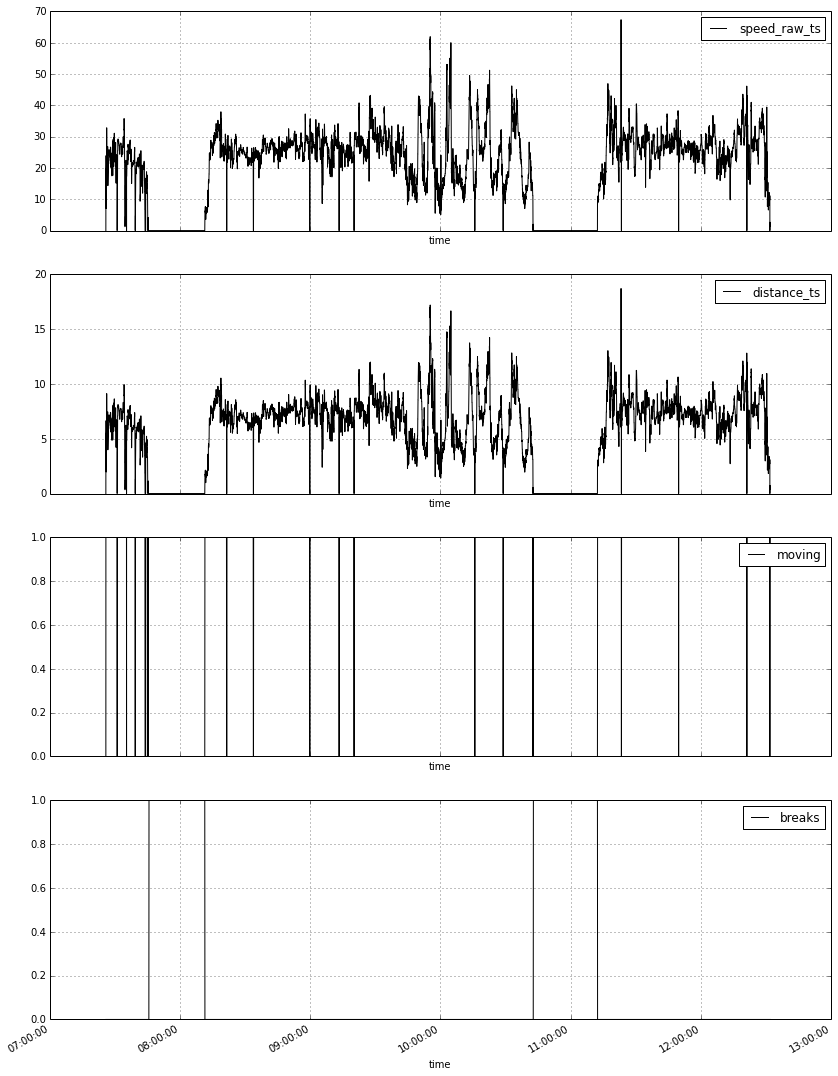

In [7]:
#plot all columns
#df2 = df[ ['speed_raw_ts','distance_ts', 'moving', 'breaks' ] ]
_ = df.plot(subplots=True, 
        figsize=(14, 20),
         xlim=(datetime(2015,9,13,6,0,0),datetime(2015,9,13,12,0,0 )),
        )
update = {'data':[{'fill': 'tozeroy'}]}  # this updates the trace


In [8]:
dir(matplotlib)
matplotlib.__version__
# need to upgrade to 1.4
# need to use kind = 'area'

NameError: name 'matplotlib' is not defined

## Exploring the Raw Speed Data

The analysis shows that a simple raw speed calculation (distance divided by time) gives a mis-leading representation of the rider's speed.  A simple speed calculation is not robust and is susceptible to outlier data.  This notebook identifies an outlier and applies an moving average algorithm to fix the outlier.  A algorothm must be applied to give reliable speed data.  This algorithm is the time series average speed algorithm.  A finding is that a three second moving average works best - but this approach is flexible, so other values and other algorothns can be used.


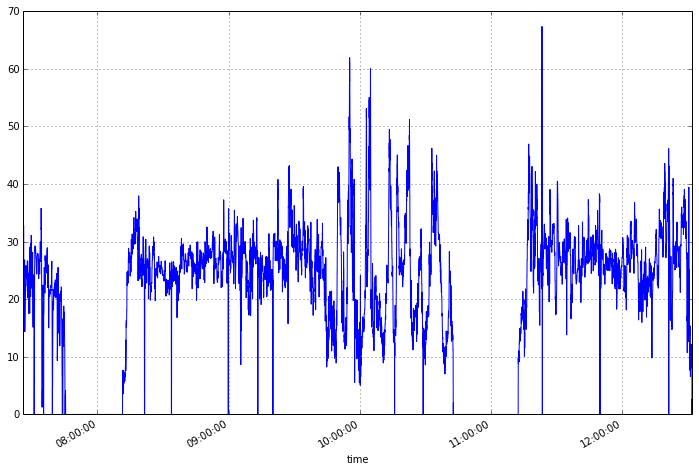

In [9]:
#import matplotlib
#matplotlib.style.use('ggplot')
#Plot the speed data for all data points
_ = df['speed_raw_ts'].plot( figsize=(12,8),)

The plot of raw speed shows a number of speed spikes.  Lets explore the speed spikes greater than 60km/hr

## Point in Time Analytics

### Define Time Window Function

In [34]:
# function to allow us to zoom into specific time windows
def get_window_range(dataframe, center_index, window):
    '''
    Return the index at the start and end of given time window for a specific data frame
    
    Input: 
        dataframe - name of dataframe
        center_index - time index in center of window
        window - time window, interval size in seconds
        
    Output:
        index_start - start index for time window
        index_end - end index
    
    '''
    interval = timedelta(seconds=window/2)
    index_start =  center_index - interval
    index_end = center_index + interval
    
    return index_start, index_end

### Event A -  Maximum Raw Speed
The first event we focus on is maximum raw speed of 67 km/hr
- Need to get exact time to second of max raw speed
- Store this time in the variable time_point_1
- Set up a 60 second time window with time_point_1 in centre
- Plot raw speed for this time window
- Calculate time series rolling average values 
- Compare raw speed and rolling average

#### Time of maximum raw speed

In [23]:
# find the row where raw speed is maximum
df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], ascending = False)[0:1]

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 11:23:16+01:00,67.359375,18.710938,True,False


In [28]:
#store this time point in variable time_point_1
time_point_1 = \
            df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], 
                        ascending = False).index[0:1][0]

#### Graph Raw Speed for 60 second time window

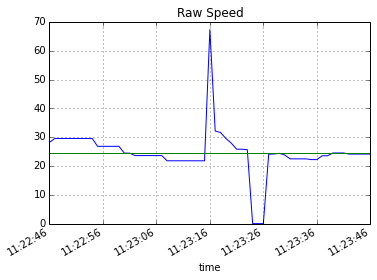

In [102]:
# define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(df, time_point_1, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()
max_raw_speed = df['speed_raw_ts'][ index_start: index_end ].max()

plt.figure()
plt.title('Raw Speed')
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(5.75,4),)
_ = plt.axhline(avg_speed, color='g')


In [48]:
print("The above diagram shows a data spike at {}".format(str(time_point_1)) )
print("The max speed of {:.1f} km/h is far in excess of the average speed of {:.1f} km/h"\
     .format( max_raw_speed, avg_speed ))

The above diagram shows a data spike at 2015-09-13 11:23:16+01:00
The max speed of 67.4 km/h is far in excess of the average speed of 24.6 km/h


#### Rolling Average Speed for 60 second time window centred on max raw speed

In [104]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 2

49.8


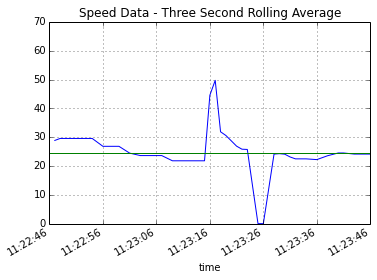

In [105]:
# here we apply the time series rolling average algorithm
# I experimented with various intervals , found 3 second interval worked best
plt.figure()
plt.ylim( (0,70) )
plt.title('Speed Data - Three Second Rolling Average')
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , window_size_seconds).plot(
                            figsize=(5.75,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

max_rolling_avg_speed = pd.rolling_mean( df['speed_raw_ts'][ index_start: index_end ],window_size_seconds ).max()
print( "{:.1f}".format( max_rolling_avg_speed ))

In [106]:
print("The max rolling average speed of {:.1f} km/h is close to the average speed of {:.1f} km/h"\
     .format( max_rolling_avg_speed, avg_speed ))
print("The rolling average algorithm has reduced data spike from {:.1f} km/h to {:.1f} km/h"\
     .format(max_raw_speed,max_rolling_avg_speed))


The max rolling average speed of 49.8 km/h is close to the average speed of 24.6 km/h
The rolling average algorithm has reduced data spike from 67.4 km/h to 49.8 km/h


#### Compare Raw Speed and Rolling Average Speed Calculations

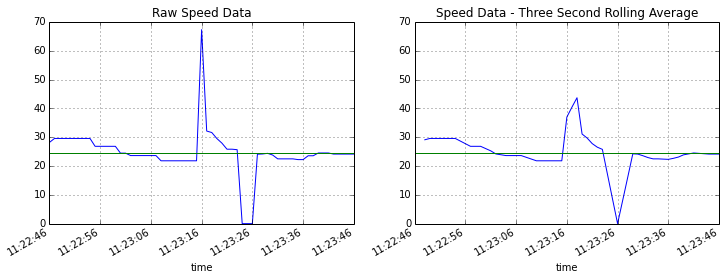

In [59]:
#generate two plots to compare raw speed with rolling average speed
plt.figure()
 plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

The speed spike is the only data point that is changed dramatically by the rolling average algorithm - it has almost no impact on the other data points.

The smoothing algorithm gives the more realistic representation of the actual speed.

### Event B -  Second Highest Raw Speed
The second event we focus on is the second highest raw speed of 61.9 km/hr
- Need to get exact time to second of this raw speed
- Store this time in the variable time_point_2
- Set up a 40 second time window with time_point_2 in centre
- Plot raw speed for this time window
- Calculate time series rolling average values 
- Compare raw speed and rolling average

#### Time of second highest raw speed

In [53]:
# find the row where raw speed is second highest
df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], ascending = False)[1:2]

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False


In [57]:
#store this time point in variable time_point_2
time_point_2 = \
            df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], 
                        ascending = False).index.tolist()[1:2][0]

#### Graph Raw Speed for 40 second time window

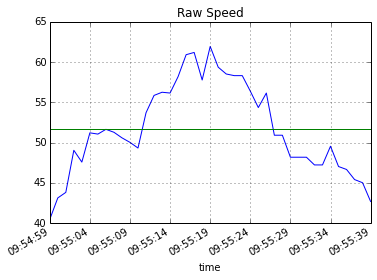

In [60]:
# define the width of the time window in seconds
time_window_seconds = 40

# Find the start and end time indexes for the window
index_start, index_end = get_wintime_point_2dow_range(df, time_point_2, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()
max_raw_speed = df['speed_raw_ts'][ index_start: index_end ].max()

plt.figure()
plt.title('Raw Speed')
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(5.75,4),)
_ = plt.axhline(avg_speed, color='g')

In [63]:
print("The above diagram shows second highest speed at {}".format(str(time_point_2)) )
print("The plot shows that three of the data points exceed 60 km/hr")
print("The max speed of {:.1f} km/h compares with an average speed of {:.1f} km/h"\
     .format( max_raw_speed, avg_speed ))

The above diagram shows second highest speed at 2015-09-13 09:55:19+01:00
The plot shows that three of the data points exceed 60 km/hr
The max speed of 61.9 km/h compares with an average speed of 51.7 km/h


#### Rolling Average Speed for 40 second time window centred on second highest raw speed

61.1


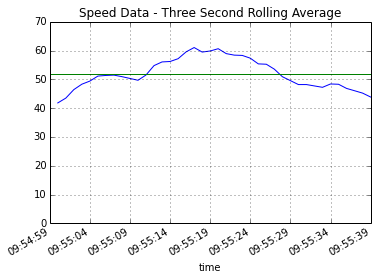

In [95]:
# here we apply the time series rolling average algorithm
# I experimented with various intervals , found 3 second interval worked best
plt.figure()
plt.ylim( (0,70) )
plt.title('Speed Data - Three Second Rolling Average')
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 2).plot(
                            figsize=(5.75,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

max_rolling_avg_speed = pd.rolling_mean( df['speed_raw_ts'][ index_start: index_end ],2 ).max()
print( "{:.1f}".format( max_rolling_avg_speed ))

In [96]:
print("The max rolling average speed of {:.1f} km/h is much closer to the average speed of {:.1f} km/h"\
     .format( max_rolling_avg_speed, avg_speed ))
print("The rolling average algorithm has reduced data spike from {:.1f} km/h to {:.1f} km/h"\
     .format(max_raw_speed,max_rolling_avg_speed))


The max rolling average speed of 61.1 km/h is much closer to the average speed of 51.7 km/h
The rolling average algorithm has reduced data spike from 61.9 km/h to 61.1 km/h


#### Compare Raw Speed and Rolling Average Speed Calculations

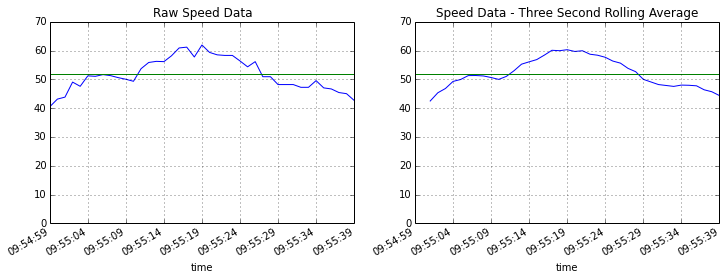

In [66]:
#generate two plots to compare raw speed with rolling average speed
plt.figure()
plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

Smoothing function accurately smooths the speed data.  It makes no dramatic changes - just provides a subtle data smoothing.

## Calculate Rolling Avg Speed and Save to Time Series

In [89]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 2

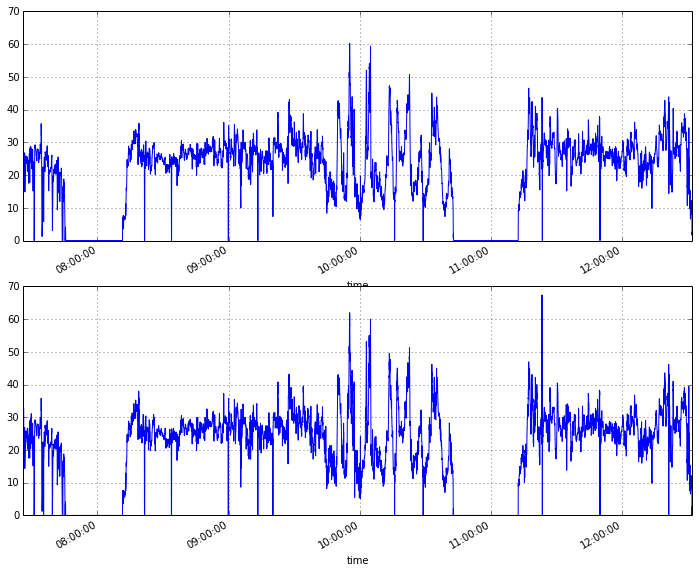

In [81]:
# graph of rolling average speed
plt.figure()
plt.subplot(2,1,1)
plt.ylim( (0,70) )
_ = pd.rolling_mean( df['speed_raw_ts'] , window_size_seconds )\
                    .fillna(0.0).plot(figsize=(12,10),)

plt.subplot(2,1,2)
plt.ylim( (0,70) )
_ = df['speed_raw_ts']\
                    .fillna(0.0).plot( )


In [82]:
# Save rolling average speed to the time series data set
df['speed_rollavg'] = pd.rolling_mean( df['speed_raw_ts'] , \
                                               window_size_seconds ).fillna(0.0)

In [87]:
# view data series
df.sort(columns = ['speed_rollavg'], ascending = False).head(5)

,speed_raw_ts,distance_ts,moving,breaks,speed_rollavg
time,,,,,
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False,60.309375
2015-09-13 09:55:17+01:00,61.200000,17.000000,True,False,60.107813
2015-09-13 09:55:18+01:00,57.782812,16.050781,True,False,59.967188
2015-09-13 09:55:21+01:00,58.528125,16.257812,True,False,59.948438
2015-09-13 09:55:20+01:00,59.371875,16.492188,True,False,59.700000


In [88]:
# run original query, checking raw speed and new rolling avg speed
df[ df['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], ascending = False)

,speed_raw_ts,distance_ts,moving,breaks,speed_rollavg
time,,,,,
2015-09-13 11:23:16+01:00,67.359375,18.710938,True,False,37.000781
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False,60.309375
2015-09-13 09:55:17+01:00,61.200000,17.000000,True,False,60.107813
2015-09-13 09:55:16+01:00,60.918750,16.921875,True,False,58.429688
2015-09-13 10:04:51+01:00,60.018750,16.671875,True,False,57.960938


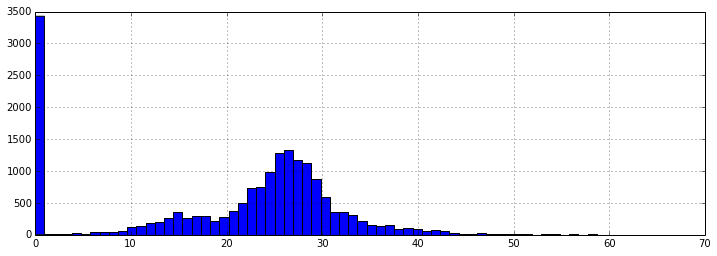

In [69]:
#check the frequency distribution of raw speed data variables
_ = df['speed_raw_ts'].hist(bins=70,
                figsize=(12,4),)

The histogram below shows that most common time interval between data points is 1 second.
However many data points have multiple seconds between data points.
